In [6]:
import glob
import numpy as np
import pandas as pd
from datetime import datetime, date
import os
import matplotlib.pyplot as plt
import plotly.express as px

from talib import RSI, BBANDS

import talib

In [7]:
data_path =  os.path.join(os.getcwd(),"nse_data\\data\\")
data_index = os.path.join(os.getcwd(),"nse_data\\index_data\\")
dump_path =  os.path.join(os.getcwd(),"nse_data\\dump\\")
meta_data =  os.path.join(os.getcwd(),"nse_data\\meta_data\\")
reports_path = os.path.join(os.getcwd(),"nse_data\\reports\\")
nse_indices = os.path.join(os.getcwd(),"nse_data\\nse_indices\\")
# print(nse_indices)

In [8]:
nifty500_df = pd.read_csv(os.path.join(nse_indices, "ind_nifty500list.csv"))
stocks_list = nifty500_df.Symbol.tolist()
len(stocks_list)

501

In [9]:
stocks_list = list(dict.fromkeys(stocks_list))

add_stocks = ['VEDL', 'YESBANK', 'SBICARD']
skip_stocks = ['BBTC','IRB','M&MFIN','PVR']

stocks_list = stocks_list + add_stocks
stocks_list = sorted(set(stocks_list)-(set(skip_stocks)))
len(stocks_list)

# stocks_list = random.sample(stocks_list, len(stocks_list))

499

In [5]:
# Function to get script data file path if present
def get_stock_file_path(script):
    for file in glob.glob(data_path + script + '_*.csv'):
        file = file.replace("\\","/")
        return(file)
    
def get_stock_filename(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)
    
# Function to check if the script data file already present or not: True or False
def stock_data_present(script):
    file = get_stock_file_path(script)
    if file:
        return True
    return False

# Function to get stock dataframe from script name
def stock_df_from_csv(script):
    file = get_stock_file_path(script)
    stock_df = pd.read_csv(file)
    return stock_df

# Function to get stock dataframe from script name with Date as Index
def get_df_date_index(stock):
    df = stock_df_from_csv(stock)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', drop=True, inplace = True)
    df.index.name = None
    return df

def calculate_sma(df , t = 30 , field = 'Close'):
    sma = talib.SMA(df[field], timeperiod = t)
    sma.name = 'sma'+ str(t)
    sma = sma.to_frame()
    df = df.merge(sma, left_index=True, right_index=True)
    return df

In [6]:
start_date = '2020-09-24'
end_date = date.today()

df = get_df_date_index("TCS")
last_updated_date = df.index.max()
last_updated_date

Timestamp('2021-05-21 00:00:00')

In [7]:
# Function to create Golden Cross Report

def golden_cross_report(stocks):
    golden_df = []
    for stock in stocks:
        df = get_df_date_index(stock)
        df = calculate_sma(df, 50)
        df = calculate_sma(df, 200)
        df = df[start_date:end_date]
        df = df[["Close","sma50","sma200"]]
        df = np.round(df, decimals=4)
        df.index.name ="Date"
        df = df.reset_index()
#         display(df)
        for ind in df.index: 
#             print(ind-1)
            if ind+1 < df.shape[0]:
                if (df['sma50'][ind] < df['sma200'][ind] ) & (df['sma50'][ind+1] > df['sma200'][ind+1]):
#                     print(stock ,df['Date'][ind] , df['sma50'][ind] , df['sma200'][ind] , df['sma50'][ind+1] , df['sma200'][ind+1] , sep = "\t\t")
                    golden_df.append(
                                {   'Stock': stock,
                                    'Date': df['Date'][ind],
                                    'SMA50':df['sma50'][ind],
                                    'SMA200':df['sma200'][ind]
                                })
                    golden_df.append(
                                {   'Stock': stock,
                                    'Date': df['Date'][ind+1],
                                    'SMA50':df['sma50'][ind+1],
                                    'SMA200':df['sma200'][ind+1]
                                }
                        
                            )
    return pd.DataFrame(golden_df)

 

# Function to create Death Cross Report

def death_cross_report(stocks):
    death_df = []
    for stock in stocks:
        df = get_df_date_index(stock)
        df = calculate_sma(df, 50)
        df = calculate_sma(df, 200)
        df = df[start_date:end_date]
        df = df[["Close","sma50","sma200"]]
        df = np.round(df, decimals=4)
        df.index.name ="Date"
        df = df.reset_index()
#         display(df)
        for ind in df.index: 
#             print(ind-1)
            if ind+1 < df.shape[0]:
                if (df['sma50'][ind] > df['sma200'][ind] ) & (df['sma50'][ind+1] < df['sma200'][ind+1]):
#                     print(stock ,df['Date'][ind] , df['sma50'][ind] , df['sma200'][ind] , df['sma50'][ind+1] , df['sma200'][ind+1] , sep = "\t\t")
                    death_df.append(
                                {   'Stock': stock,
                                    'Date': df['Date'][ind],
                                    'SMA50':df['sma50'][ind],
                                    'SMA200':df['sma200'][ind]
                                })
                    death_df.append(
                                {   'Stock': stock,
                                    'Date': df['Date'][ind+1],
                                    'SMA50':df['sma50'][ind+1],
                                    'SMA200':df['sma200'][ind+1]
                                }
                        
                            )
    return pd.DataFrame(death_df)

In [8]:
# Create Golden-Death Cross Report
gc_report_df = golden_cross_report(stocks_list)
dc_report_df = death_cross_report(stocks_list)

update_date = pd.to_datetime(last_updated_date)
datetime_obj = update_date.to_pydatetime().date() 

golden_death_cross_file = reports_path + 'Golden_Death_Cross_Report_' + datetime_obj.strftime('%d-%m-%Y') + '.xlsx'

with pd.ExcelWriter(golden_death_cross_file) as writer:  
    gc_report_df.to_excel(writer, sheet_name='Golden Cross')
    dc_report_df.to_excel(writer, sheet_name='Death Cross')
 
print(golden_death_cross_file, ' Saved to Disk')

C:\Users\Anirudh\Desktop\Technical_Analysis\nse_data\reports\Golden_Death_Cross_Report_21-05-2021.xlsx  Saved to Disk


In [ ]:
# # Create Death Cross Report
# dc_report_df = death_cross_report(stocks_list)
# update_date = pd.to_datetime(last_updated_date)
# datetime_obj = update_date.to_pydatetime().date() 
# death_cross_file = reports_path + 'Death_Cross_Report_' + datetime_obj.strftime('%d-%m-%Y') + '.csv'
# dc_report_df.to_csv(death_cross_file, index = True)
# print(death_cross_file, ' Saved to Disk')

In [230]:
# # Function to create Golden Cross Nearby Report

# def golden_cross_nearby_report(stocks , percent):
#     golden_near_df = []
#     for stock in stocks:
#         df = get_df_date_index(stock)
#         df = calculate_sma(df, 50)
#         df = calculate_sma(df, 200)
#         df = df[start_date:end_date]
#         df = df[["Close","sma50","sma200"]]
#         df = np.round(df, decimals=4)
#         df.index.name ="Date"
#         df = df.reset_index()
# #         display(df)
#         for ind in df.index: 
# #             print(ind-1)
#             if ind+1 < df.shape[0]:
#                 if (df['sma50'][ind] < df['sma200'][ind] ) & (((df['sma200'][ind]- df['sma50'][ind] )*100/df['sma50'][ind]) < percent ):
# #                     print(stock ,df['Date'][ind] , df['sma50'][ind] , df['sma200'][ind] , df['sma50'][ind+1] , df['sma200'][ind+1] , sep = "\t\t")
#                     golden_near_df.append(
#                                 {   'Stock': stock,
#                                     'Date': df['Date'][ind],
#                                     'SMA50':df['sma50'][ind],
#                                     'SMA200':df['sma200'][ind],
#                                     'Percent':((df['sma200'][ind]- df['sma50'][ind] )*100/df['sma50'][ind])
#                                 }                       
#                             )
#     return pd.DataFrame(golden_near_df)

        

In [232]:
# # Create Golden Cross Nearby Report
# start_date = '2020-08-01'
# percent = 3

# gc_near_report_df = golden_cross_nearby_report(stocks_list , percent)
# update_date = pd.to_datetime(last_updated_date)
# datetime_obj = update_date.to_pydatetime().date() 
# golden_cross_near_file = reports_path + 'Golden_Cross_Nearby_'+str(percent)+"_percent_" + datetime_obj.strftime('%d-%m-%Y') + '.csv'
# gc_near_report_df.to_csv(golden_cross_near_file, index = True)
# print(golden_cross_near_file, ' Saved to Disk')

C:\Users\Anirudh\Desktop\Technical_Analysis\nse_data\reports\Golden_Cross_Nearby_3_percent_09-08-2020.csv  Saved to Disk


(5144, 14)
(5186, 16)
(6, 16)
(6, 3)


,Close,sma50,sma200
2020-09-01,689.60,654.802,611.67725
2020-09-02,701.95,657.649,609.47550
2020-09-03,706.75,660.783,607.30375
2020-09-04,700.80,663.551,605.13450
2020-09-07,708.80,666.653,603.01450
2020-09-08,725.90,670.034,600.96100


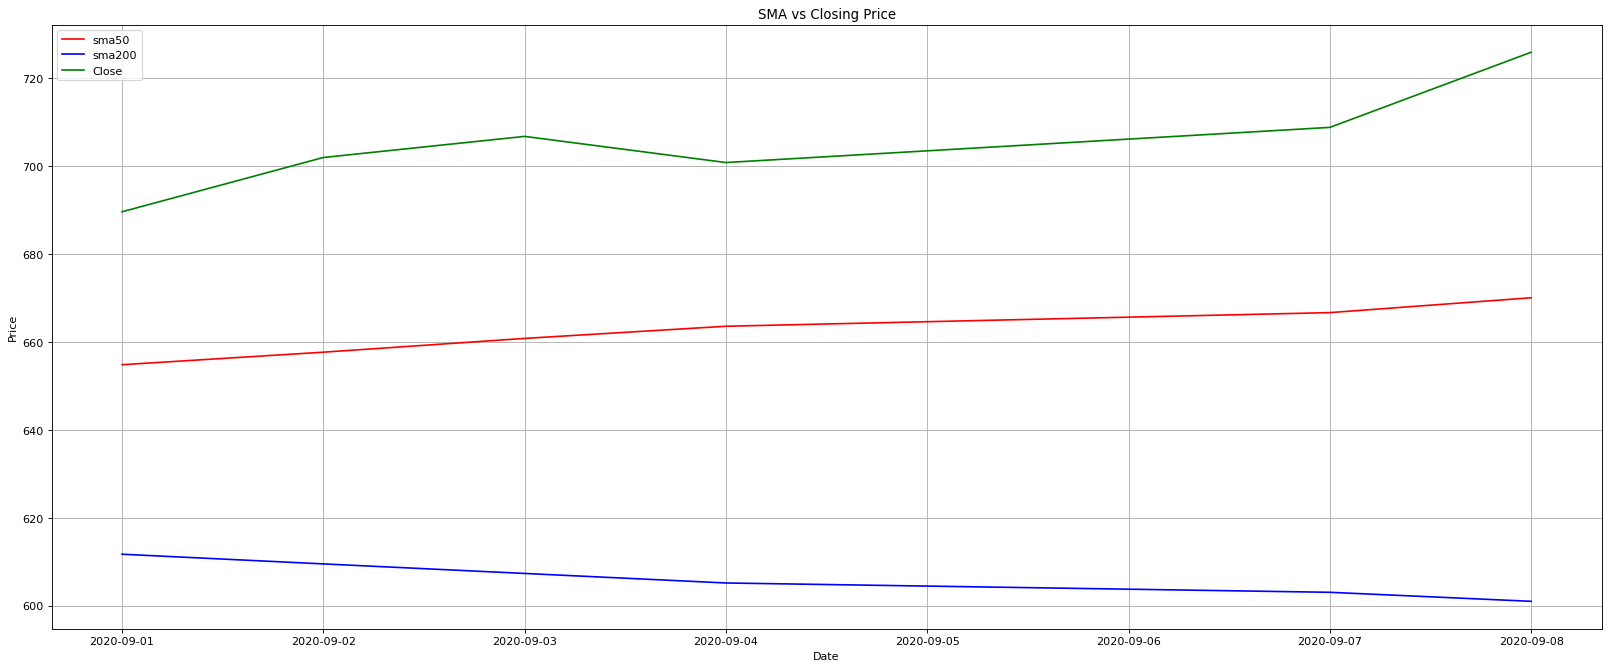

In [17]:

df = get_df_date_index('HCLTECH')   
print(df.shape)

df = calculate_sma(df, 50)
df = calculate_sma(df, 200)
print(df.shape)
# df.to_csv("TCS_sma_50_200.csv", index = True)

df = df[start_date:end_date]
print(df.shape)


df = df[["Close","sma50","sma200"]]
print(df.shape)
display(df)
# display(df.tail(5))



# *********************************************************************************************
# Create Matplotlib Line plot for SMA -50 -200

plt.figure(num=None, figsize=(25,10), dpi=80, facecolor='w', edgecolor='k')

# plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SMA vs Closing Price')
plt.plot( df.sma50 ,label='sma50', color="red")
plt.plot( df.sma200 ,label='sma200', color="blue")
plt.plot(df.Close, label='Close',color="green")
plt.grid()
plt.legend()

plt.show()

In [18]:
df.tail(20)

,Close,sma50,sma200
2020-09-01,689.60,654.802,611.67725
2020-09-02,701.95,657.649,609.47550
2020-09-03,706.75,660.783,607.30375
2020-09-04,700.80,663.551,605.13450
2020-09-07,708.80,666.653,603.01450
2020-09-08,725.90,670.034,600.96100


In [19]:
# Create Plotly Line plot for SMA -50 -200

df.index.name ="Date"
df =df.reset_index()
df = pd.melt(df, id_vars=["Date"], var_name = "Indicator", value_name = "Value")


fig = px.line(df, x = "Date",  y = 'Value', color = "Indicator", title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()